In [20]:
import sys
from pathlib import Path
from IPython.display import display
from functools import partial
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import joblib

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, accuracy_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import optuna
import ray
from ray import tune

import interpret
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression
from interpret.perf import ROC
# explain_perf 
# interpret.show()
interpret.set_visualize_provider(interpret.provider.InlineProvider())

# Dataset

In [21]:
with open('../data/all_data.pickle', 'rb') as file:
    all_data = pickle.load(file)

orig_characteristics = all_data['OrigCharacteristics.dta']
orig_characteristics_columns = [
    #'Deal',
    'type',
    'CutoffLTV',
    'CutoffDSCR',
    'CutoffCpn',
    'log_bal',
    'fixed',
    'buildingage',
    'CutoffOcc',
    # 'year_priced',
    'quarter_type',
    'AmortType',
    # 'MSA',
    # 'qy',
    'Size',

    'OVER_w',
    'past_over',
    'high_overstatement2', # is 100% dependent on Over_w, if we predict this we get 100% accuracy
    'Distress',
    #'non_perf'
]
orig_data = orig_characteristics[orig_characteristics_columns]
target_col = 'Distress'
orig_data_with_dummies = pd.get_dummies(
    orig_data,
    columns=[
        'AmortType',
        # 'MSA',
        'type',
        # 'year_priced'
    ]
)
clean_data = orig_data_with_dummies[
    orig_data_with_dummies.notna().all(axis=1)
]

dummy_cols = [col for col, dtype in clean_data.dtypes.items() if dtype == bool]
for dummy_col in dummy_cols:
    clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})

# Percentage of clean data from whole dataset
print('percentage of clean data and all data ', len(clean_data) / len(orig_data_with_dummies))

y = clean_data[target_col].astype('U32')
X = clean_data.drop(columns=target_col)

sample_size = len(y)
print('sample size ', sample_size)

percentage of clean data and all data  0.6194031714321389
sample size  24804


/var/folders/pr/tf6fbkqx6mv5m13cy7d765fw0000gn/T/ipykernel_6865/2929114164.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[dummy_col] = clean_data[dummy_col].map({True: 1, False:0})


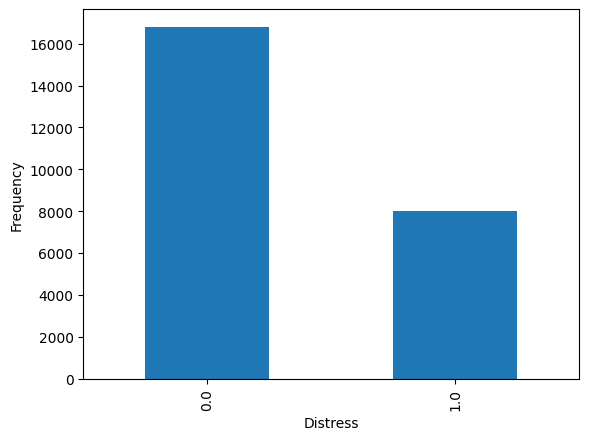

In [22]:
# ax = y.astype('float').plot(kind='hist',title='')
ax = y.value_counts().plot.bar()
ax.set_ylabel('Frequency')
fig = ax.get_figure()
fig.savefig('../plots/Distress_class_imbalance.png',format='png', bbox_inches='tight')


# Explainable Boosting Machine

#### Use EBM parameters that performed with highest ROC whilst training

In [31]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_ebm_maximize.joblib', 'rb') as file:
    ebm_configs = joblib.load(file)['params']

ebm_configs

{'greediness': 0.007,
 'max_bins': 340,
 'inner_bags': 0,
 'outer_bags': 8,
 'max_rounds': 5000,
 'early_stopping_rounds': 40,
 'learning_rate': 0.0009,
 'smoothing_rounds': 4}

In [33]:
ebm = ExplainableBoostingClassifier(**ebm_configs)

In [34]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [35]:
ebm.fit(X_oversampled, y_oversampled)

ExplainableBoostingClassifier(early_stopping_rounds=40, greediness=0.007,
                              learning_rate=0.0009, max_bins=340,
                              smoothing_rounds=4)

In [36]:
interpret.show(ebm.explain_global())

In [37]:
interpret.show(ROC(ebm).explain_perf(X, y, name='ROC EBM'))

#### Use EBM parameters that performed with lowest ROC whilst training

In [40]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_ebm_minimize.joblib', 'rb') as file:
    ebm_configs_min = joblib.load(file)['params']

ebm_configs_min

{'greediness': 0.009000000000000001,
 'max_bins': 198,
 'inner_bags': 3,
 'outer_bags': 8,
 'max_rounds': 5500,
 'early_stopping_rounds': 40,
 'learning_rate': 0.0013,
 'smoothing_rounds': 0}

In [41]:
ebm_min = ExplainableBoostingClassifier(**ebm_configs_min)

In [ ]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [42]:
ebm_min.fit(X_oversampled, y_oversampled)

ExplainableBoostingClassifier(early_stopping_rounds=40,
                              greediness=0.009000000000000001, inner_bags=3,
                              learning_rate=0.0013, max_bins=198,
                              max_rounds=5500)

In [43]:
interpret.show(ebm_min.explain_global())

In [44]:
interpret.show(ROC(ebm_min).explain_perf(X, y, name='ROC EBM'))

# Logistic Regression

#### Use Logistic Regression parameters that performed with highest ROC whilst training

In [23]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_LR_maximize.joblib', 'rb') as file:
    lr_configs = joblib.load(file)['params']

lr_configs

{'penalty': 'l2',
 'C': 0.001,
 'class_weight': None,
 'max_iter': 1500,
 'solver': 'newton-cg'}

In [24]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

In [28]:
lr_model = LogisticRegression(**lr_configs)
# lr_model.fit(X, y)
lr_model.fit(X_oversampled, y_oversampled)

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

/Users/janik/Documents/Master/KIT/Semester4/Advanced_Machine_Learning_Projekt/.venv/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge



In [29]:
interpret.show(lr_model.explain_global())

In [30]:
interpret.show(ROC(lr_model).explain_perf(X, y, name='ROC Logistic Regression (max)'))

#### Use Logistic Regression parameters that performed with lowest ROC whilst training

In [32]:
# load configs that were determined via cross validated hyperparameter tuning
with open('../models/best_params_LR_minimize.joblib', 'rb') as file:
    lr_configs_min = joblib.load(file)['params']

lr_configs_min

{'penalty': 'l2',
 'C': 1.501,
 'class_weight': None,
 'max_iter': 9500,
 'solver': 'newton-cholesky'}

In [1]:
X_oversampled, y_oversampled = SMOTE().fit_resample(X, y)

NameError: name 'SMOTE' is not defined

In [44]:
lr_model_min = LogisticRegression(**lr_configs_min)
lr_model_min.fit(X_oversampled, y_oversampled)

In [45]:
interpret.show(lr_model_min.explain_global())

In [46]:
interpret.show(ROC(lr_model_min).explain_perf(X, y, name='ROC Logistic Regression (min)'))